In [283]:
try:
    import import_ipynb
except :
    !pip install import_ipynb
    import import_ipynb
import Predistim_Library as pl

In [284]:
import os
import pandas as pd
from scipy.io import loadmat
import glob
from plotnine import ggplot, aes, geom_point, labs
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_errorbar, geom_line, geom_point, labs, theme_minimal
import nibabel as nib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import statsmodels.api as sm
import plotly.express as px


# Récuperer les valeurs UPDRS 

In [290]:
df_age_hy = pd.read_excel(os.path.join(pl.STUDY_PATH, "csv_xlsx", "Bio_Ima_Gen_V3_20210205_2.xlsx"), engine='openpyxl')
df_age_hy.set_index("PatientID", inplace=True)
df_age_hy.index = df_age_hy.index.str.slice(0, 2).str.cat(df_age_hy.index.str.slice(2,-2), sep="-")
# Filtrer les sujets ayant Age > 55 et HY_OFF_V0 dans la plage (0, 3)
#filtered_subjects = df_age_hy[(df_age_hy['Age'] > 55) & (df_age_hy['HY_OFF_V0'] > 0) & (df_age_hy['HY_OFF_V0'] < 3)]
filtered_subjects = df_age_hy#[(df_age_hy['Age'] > 55) & (df_age_hy['HY_OFF_V0'] > 0) & (df_age_hy['HY_OFF_V0'] < 3)]

# Récupérer les patients avec age > 55 et Hoen & Yard =1 ou 2

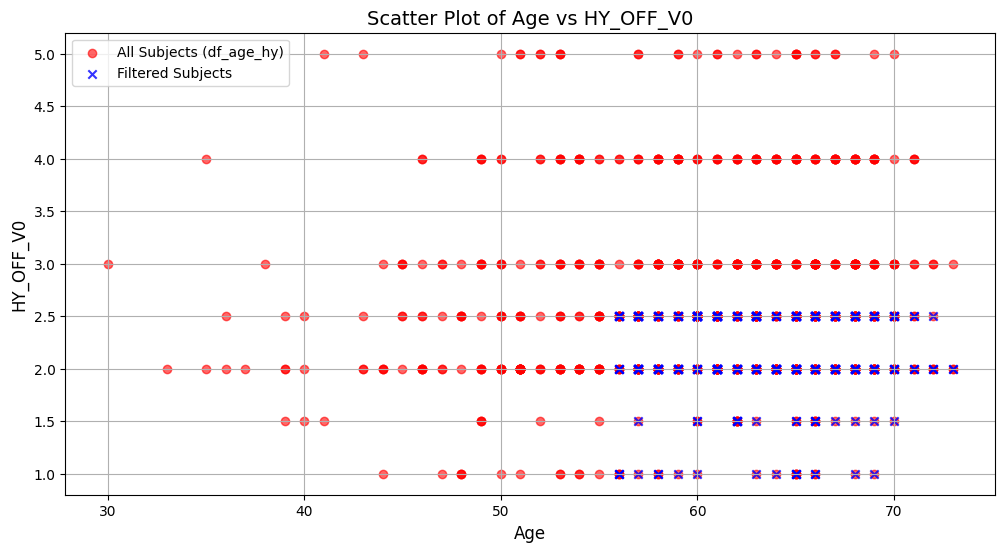

In [286]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df_age_hy['Age'], df_age_hy['HY_OFF_V0'], color='red', label='All Subjects (df_age_hy)', alpha=0.6)
plt.scatter(filtered_subjects['Age'], filtered_subjects['HY_OFF_V0'], color='blue', marker='x', label='Filtered Subjects', alpha=0.8)

# Add title and labels
plt.title("Scatter Plot of Age vs HY_OFF_V0", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("HY_OFF_V0", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Save the plot as a JPEG file
plt.savefig("/NAS/deathrow/protocoles/predistim/screenshots/scatter_age_vs_hy_off_v0.jpeg", format='jpeg', dpi=300)

# Show the plot
plt.show()


In [291]:
#1
df_msa = pd.read_excel(os.path.join(pl.STUDY_PATH, "csv_xlsx", "Romain_Juin2025.xlsx"), engine='openpyxl',sheet_name='UPDRSIII_COMPLET_V0')
#print(df_msa.head())
df_msa.set_index("SUBJID", inplace=True)

#2
# Afficher toutes les colonnes contenant "DROIT" dans leur nom
droit_columns = df_msa.filter(regex="OF.*_.*DROIT", axis=1).columns
#print(len(droit_columns),droit_columns)

# Afficher toutes les colonnes contenant "DROIT" dans leur nom
gauche_columns = df_msa.filter(regex="OF.*_.*GCHE", axis=1).columns

df_msa['somme_droit'] = df_msa[droit_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa['somme_gauche'] = df_msa[gauche_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa['asymetry'] = df_msa['somme_droit'] - df_msa['somme_gauche']
df_msa['asymetry'].dropna(inplace=False)

/tmp/ipykernel_717220/1864820306.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_717220/1864820306.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_717220/1864820306.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



SUBJID
Subject Identifier for the Study    0.0
01-001                              3.0
01-002                              1.0
01-003                              4.0
01-004                              2.0
                                   ... 
20-025                             -2.0
20-026                             -6.0
20-027                              2.0
20-028                              0.0
20-029                             -1.0
Name: asymetry, Length: 836, dtype: float64

# read mat files for building a dataframe 

attention pas terrible je prefere utilise les fichiers txt generés avec fslstats cf ..ci dessous 

exemple : fslstats -K /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-18009RJ_ses-M00/mrGrad/mrGradSeg/subjectgroup_1/sub-18009RJ_ses-M00/mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-18009RJ_ses-M00/r2_norm_PSR.nii.gz -M > /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-18009RJ_right-putamen_axis1_7segments_r2_norm_values.txt


In [ ]:
mat_data_tmp = loadmat("/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01024FC_ses-M00/mrGradT1only/mrGrad_t1overt2.mat")
y_data_0 = np.array(mat_data['RG'][0][0]['Y'][0][0][0][0]).flatten()
y_data_1 = np.array(mat_data['RG'][0][1]['Y'][0][0][0][0]).flatten()

# Production des fichiers txt contenant les valeurs moyen par segment avec fslstats

In [302]:
# Chemin vers le répertoire contenant les données des patients
base_dir = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2"
sorted_patient_dirs = sorted(glob.glob(os.path.join(base_dir, "sub-*00")))

# Parcourir les répertoires des patients
for patient_dir in sorted_patient_dirs:
    # Extraire l'ID du patient à partir du nom du répertoire
    patient_id = os.path.basename(patient_dir)
    #print(f"Traitement du patient : {patient_id}")

    # Chemins des fichiers pour le patient actuel
    # t1overt2_file = os.path.join(patient_dir, "t1overt2_norm_PSR.nii.gz")
    # t1overt2_file = os.path.join(patient_dir, "T1overT2_N4_medianNorm.nii.gz")
    t1overt2_file = os.path.join(patient_dir, "T1overT2_Elior_d2_medianNorm.nii.gz")    
    # t1overt2_file = os.path.join("/NAS/deathrow/protocoles/predistim/R2",patient_id[4:11] ,"R2_lin_3DT1.nii.gz")
    # t1overt2_file = os.path.join(patient_dir, "t2_LAS.nii.gz")
    left_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii")
    right_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii")
    # Vérifier si les fichiers existent
    if not all(os.path.exists(f) for f in [t1overt2_file, left_seg_file, right_seg_file]):
        #print(f"Fichiers manquants pour le patient {patient_id}, passage au suivant.")
        continue

    #print(f"freeview -layout 1 -viewport axial {t1overt2_file}:grayscale=0,10 {right_seg_file}:colormap=lut:opacity=0.5 {left_seg_file}:colormap=lut:opacity=0.5;")
    #print(f"python inverseROInumber.py {right_seg_file}")
    #print(f"python inverseROInumber.py {left_seg_file}")   

    command = (
        f"qbatch -q three_job_q -oe /NAS/dumbo/protocoles/PACTE1/scripts/log/ -N p_w{patient_id} eval \""
        #f"mri_convert {t1overt2_file} -rl {left_seg_file} {t1overt2_file.replace('.nii.gz','_rlon3DT1.nii.gz')};"
        # f"fslstats -K {left_seg_file} {t1overt2_file.replace('.nii.gz','_rlon3DT1.nii.gz')} -M > {patient_dir}_patient_id_left-putamen_axis1_7segments_t2w_values.txt;"
        # f"fslstats -K {right_seg_file} {t1overt2_file.replace('.nii.gz','_rlon3DT1.nii.gz')} -M > {patient_dir}_patient_id_right-putamen_axis1_7segments_t2w_values.txt;\""
        f"fslstats -K {left_seg_file} {t1overt2_file} -M > {patient_dir}_patient_id_left-putamen_axis1_7segments_T1overT2_Elior_d2_values_VolbrainSeg.txt;"
        f"fslstats -K {right_seg_file} {t1overt2_file} -M > {patient_dir}_patient_id_right-putamen_axis1_7segments_T1overT2_Elior_d2_values_VolbrainSeg.txt;\""
    )
    if not os.path.exists(f"{patient_dir}_patient_id_left-putamen_axis1_7segments_T1overT2_Elior_d2_values_VolbrainSeg.txt"):
        print(command)

qbatch -q three_job_q -oe /NAS/dumbo/protocoles/PACTE1/scripts/log/ -N p_wsub-01001SR_ses-M00 eval "fslstats -K /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01001SR_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-01001SR_ses-M00/mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01001SR_ses-M00/T1overT2_Elior_d2_medianNorm.nii.gz -M > /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01001SR_ses-M00_patient_id_left-putamen_axis1_7segments_T1overT2_Elior_d2_values_VolbrainSeg.txt;fslstats -K /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01001SR_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-01001SR_ses-M00/mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub

# solution en python mais plus lente 

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def process_patient(patient_dir):
    import os
    import numpy as np
    import nibabel as nib

    patient_id = os.path.basename(patient_dir)
    t1overt2_file = os.path.join(patient_dir, "t1overt2_norm_PSR.nii.gz")
    left_seg_file = os.path.join(patient_dir, "mrGrad", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii")
    right_seg_file = os.path.join(patient_dir, "mrGrad", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii")

    if os.path.exists(t1overt2_file) and os.path.exists(left_seg_file) and os.path.exists(right_seg_file):
        img = nib.load(t1overt2_file)
        img_data = img.get_fdata()
        seg_left_data = nib.load(left_seg_file).get_fdata()
        seg_right_data = nib.load(right_seg_file).get_fdata()
        mask_left = seg_left_data > 4
        mask_right = seg_right_data > 4
        mean_left = img_data[mask_left].mean() if np.any(mask_left) else np.nan
        mean_right = img_data[mask_right].mean() if np.any(mask_right) else np.nan
        return patient_id, mean_left, mean_right
    else:
        return patient_id, np.nan, np.nan

results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_patient, patient_dir) for patient_dir in sorted_patient_dirs]
    for future in as_completed(futures):
        patient_id, mean_left, mean_right = future.result()
        print(f"{patient_id}: Left={mean_left}, Right={mean_right}")
        results.append((patient_id, mean_left, mean_right))


sub-01002TM_ses-M00: Left=1.6608031566550092, Right=1.5574397850353983
sub-01006DF_ses-M00: Left=1.329090098145356, Right=1.3903092002266677
sub-01003SJ_ses-M00: Left=1.3499601258980958, Right=1.318063988495145
sub-01005LB_ses-M00: Left=1.218159922494522, Right=1.1858552709209005
sub-01001SR_ses-M00: Left=1.0759670760533582, Right=1.1784864481626534
sub-01008GM_ses-M00: Left=1.3222215548324372, Right=1.2359176432745798
sub-01007HC_ses-M00: Left=1.2063741409899573, Right=1.077809945893325
sub-01004DJ_ses-M00: Left=1.7291273915192538, Right=1.6410706873395955
sub-01009WF_ses-M00: Left=1.3421948858036, Right=1.3205426726358156
sub-01010VD_ses-M00: Left=1.0942988732698802, Right=1.065175777249057
sub-01011BB_ses-M00: Left=1.186236330909779, Right=1.1846027451848227
sub-01012BB_ses-M00: Left=1.2675700574264832, Right=1.2951552591114637
sub-01017TA_ses-M00: Left=1.4012763862833013, Right=1.2982197630604477
sub-01013PR_ses-M00: Left=1.4858015347849487, Right=1.4215880633008724
sub-01015HC_ses

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f729695ca10>>
Traceback (most recent call last):
  File "/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Chemin vers les fichiers
base_path = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/"
#file_pattern = "sub-*/mrGrad/mrGrad_t1overt2.mat"
file_pattern = "sub-*/mrGradT1only/mrGrad_t1overt2.mat"
#file_pattern = "sub-*/mrGradQSMoverR2/mrGrad_t1overt2.mat"
#file_pattern = "sub-*/mrGradR2/mrGrad_t1overt2.mat"

# Récupérer les chemins des fichiers
# Ensure glob_files function exists and works correctly
try:
    file_paths = glob.glob(os.path.join(base_path, file_pattern), recursive=True)
except AttributeError as e:
    print(f"Error: {e}. Ensure 'glob_files' is implemented in 'Predistim_Library'.")
    file_paths = []  # Fallback to an empty list if there's an error

# Initialiser une liste pour stocker les données
data = []

# Parcourir les fichiers et charger les données
for file_path in file_paths:
    #subject_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))  # Extraire le nom du sujet
    mat_data = loadmat(file_path)  # Charger le fichier .mat
    try:
        subject_names = str(mat_data['RG'][0][0]['subject_names'][0][0][0][0][0])
        print(subject_names)
        # Extract and store data with labels
        try:
            roi_label_0 = mat_data['RG'][0][0]['ROI_label'][0][0][0]
            roi_label_1 = mat_data['RG'][0][1]['ROI_label'][0][0][0]
            y_data_0 = np.array(mat_data['RG'][0][0]['Y'][0][0][0][0]).flatten()
            y_data_1 = np.array(mat_data['RG'][0][1]['Y'][0][0][0][0]).flatten()

            data.append({
                'subject_name': subject_names,
                f"{roi_label_0}_seg1": y_data_0[0],
                f"{roi_label_0}_seg2": y_data_0[1],
                f"{roi_label_0}_seg3": y_data_0[2],
                f"{roi_label_0}_seg4": y_data_0[3],
                f"{roi_label_0}_seg5": y_data_0[4],
                f"{roi_label_0}_seg6": y_data_0[5],
                f"{roi_label_0}_seg7": y_data_0[6],
                f"{roi_label_1}_seg1": y_data_1[0],
                f"{roi_label_1}_seg2": y_data_1[1],
                f"{roi_label_1}_seg3": y_data_1[2],
                f"{roi_label_1}_seg4": y_data_1[3],
                f"{roi_label_1}_seg5": y_data_1[4],
                f"{roi_label_1}_seg6": y_data_1[5],
                f"{roi_label_1}_seg7": y_data_1[6],
            })
        except KeyError as e:
            print(f"KeyError: {e}. Ensure 'ROI_label' and 'Y' exist in mat_data['RG'].")
    except KeyError as e:
        print(f"KeyError: {e}. 'subject_names' not found in mat_data['RG'].")
    #data.append({'subject_name': subject_name, 'data': mat_data})

# Créer un DataFrame
df = pd.DataFrame(data).set_index('subject_name')

# Clean index
df_cleaned = df.dropna()
df_cleaned.index = df_cleaned.index.str.replace("sub-", "", regex=False)
df_cleaned.index = df_cleaned.index.str.replace("_ses-M00", "", regex=False)
df_cleaned.index = df_cleaned.index.str.slice(0, 2).str.cat(df_cleaned.index.str.slice(2,-2), sep="-")

print(df_cleaned)

sub-01010VD_ses-M00
sub-01043GC_ses-M00
sub-02074AS_ses-M00
sub-02089SL_ses-M00
sub-02087TD_ses-M00
sub-05011VJ_ses-M00
sub-05023GV_ses-M00
sub-05030DN_ses-M00
sub-05036PJ_ses-M00
sub-06078BS_ses-M00
sub-07023LG_ses-M00
sub-07029SD_ses-M00
sub-07055BC_ses-M00
sub-07058PP_ses-M00
sub-07092DH_ses-M00
sub-08018JC_ses-M00
sub-08027BB_ses-M00
sub-13031GA_ses-M00
sub-13038RS_ses-M00
sub-14009DP_ses-M00
sub-17010BG_ses-M00
sub-17020LP_ses-M00
sub-17032TJ_ses-M00
sub-17050PD_ses-M00
sub-17071PM_ses-M00
sub-19012GD_ses-M00
sub-05014BJ_ses-M00
sub-02080RM_ses-M00
sub-06003LP_ses-M00
sub-06035PD_ses-M00
sub-07021FC_ses-M00
sub-07033QJ_ses-M00
sub-07046PF_ses-M00
sub-09010NL_ses-M00
sub-11023OF_ses-M00
sub-13021DE_ses-M00
sub-13026RD_ses-M00
sub-15027LJ_ses-M00
sub-14029DC_ses-M00
sub-17068MJ_ses-M00
sub-18019CT_ses-M00
sub-19008GG_ses-M00
sub-19050PM_ses-M00
sub-04008QM_ses-M00
sub-07026BP_ses-M00
sub-01009WF_ses-M00
sub-06043VR_ses-M00
sub-04005BV_ses-M00
sub-06055CP_ses-M00
sub-06074WA_ses-M00


In [ ]:
# Chemin vers les fichiers texte
base_path = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2"
file_pattern = os.path.join(base_path, "sub-*_left-putamen_axis1_7segments_T1overT2_Elior_d2_values_VolbrainSeg.txt")
#file_pattern = os.path.join(base_path, "sub-*_left-putamen_axis1_7segments_t1overt2_values.txt")
#file_pattern = os.path.join(base_path,"sub-*_left-putamen_axis1_7segments_r2_mean_values.txt")
#file_pattern = os.path.join(base_path,"sub-*_left-putamen_axis1_7segments_t2w_values.txt")

# Récupérer tous les fichiers correspondants
files = glob.glob(file_pattern)

# Initialiser une liste pour stocker les données
data = []

# Parcourir les fichiers et extraire les données
for file in files:
    # Extraire l'identifiant du sujet à partir du chemin du fichier
    subject_id = os.path.basename(file).split("_")[0]
    
    # Lire les valeurs du fichier texte
    with open(file, "r") as f:
        values_left = [float(line.strip()) for line in f.readlines() if "missing label" not in line]

    with open(file.replace("left","right"), "r") as f:
        values_right = [float(line.strip()) for line in f.readlines() if "missing label" not in line]

    # Ajouter les données dans la liste
    data.append([subject_id] + values_left + values_right)

# Créer un DataFrame
columns = ["subject_name"] + [f"Left-Putamen_seg{i}" for i in range(1, 8)] + [f"Right-Putamen_seg{i}" for i in range(1, 8)]
df = pd.DataFrame(data, columns=columns)

# Définir l'index comme l'identifiant du sujet
df.set_index("subject_name", inplace=True)

# Clean index
df_cleaned = df.dropna()
df_cleaned.index = df_cleaned.index.str.replace("sub-", "", regex=False)
df_cleaned.index = df_cleaned.index.str.replace("_ses-M00", "", regex=False)
df_cleaned.index = df_cleaned.index.str.slice(0, 2).str.cat(df_cleaned.index.str.slice(2,-2), sep="-")

# Créer un dictionnaire pour relier l'index de df_cleaned à l'index original de df
# index_map = {cleaned_idx: orig_idx for cleaned_idx, orig_idx in zip(df_cleaned.index, df.loc[df_cleaned.index].index)}
# Afficher le DataFrame
print(df_cleaned)

              Left-Putamen_seg1  Left-Putamen_seg2  Left-Putamen_seg3  \
subject_name                                                            
01-033                 0.990635           1.029756           1.085812   
17-035                 1.005838           1.065541           1.128592   
19-005                 1.137021           1.163626           1.247907   
04-011                 1.100893           1.116610           1.175086   
06-003                 0.907538           0.936931           1.059977   
...                         ...                ...                ...   
09-007                 1.231809           1.330166           1.618901   
11-031                 1.187372           1.254553           1.433941   
17-017                 0.965423           1.041847           1.150829   
05-009                 0.873279           0.927742           1.025527   
14-013                 1.377705           1.353377           1.419254   

              Left-Putamen_seg4  Left-Putamen_seg5

In [166]:
# Créer un dictionnaire pour relier l'index original de df à l'index nettoyé (df_cleaned)
index_map = {
    orig_idx: orig_idx.replace("sub-", "").replace("_ses-M00", "")[:2] + "-" + orig_idx.replace("sub-", "").replace("_ses-M00", "")[2:-2]
    for orig_idx in df.index
}
inverse_index_map = {v: k for k, v in index_map.items()}
inverse_index_map.get('15-028')

'sub-15028BY'

récupère le nom des colonnes gauche et des colonnes droites

In [167]:
 # Graphique des lignes de putamen
left_columns = [f"Left-Putamen_seg{i}" for i in range(1, n_segments + 1)]
right_columns = [f"Right-Putamen_seg{i}" for i in range(1, n_segments + 1)]

## Calcul de l'index d'asymetrie par segment "Putamen_axis1_seg{seg}_asym"

In [168]:
# Calculate asymmetry for each segment
n_segments=7
for seg in range(1, n_segments + 1):
    left = df_cleaned[f"Left-Putamen_seg{seg}"]
    right = df_cleaned[f"Right-Putamen_seg{seg}"]
    asym = (left - right) / ((left + right) / 2)
    df_cleaned[f"Putamen_axis1_seg{seg}_asym"] = asym


In [292]:
# Calculate pp asymmetry for segments 5 to 7
pp_segments = [f"Putamen_axis1_seg{seg}_asym" for seg in range(5, 8)]
print(pp_segments)
df_cleaned["pp_asym"] = df_cleaned[pp_segments].mean(axis=1)
print(df_cleaned[pp_segments].mean(axis=1))

# Obtenir l'intersection des indices
intersection_index = df_cleaned.index.intersection(df_msa.index).intersection(filtered_subjects.index)
df_filtered = df_cleaned.loc[intersection_index]

# Créer un DataFrame avec les données communes
df_intersection = pd.DataFrame({
    'T1overT2_asymetry_seg': df_cleaned.loc[intersection_index, 'pp_asym'],
    'motor_symptom_asymetry': df_msa.loc[intersection_index, 'asymetry']
})
df_intersection.dropna(inplace=True)
print(df_intersection)

['Putamen_axis1_seg5_asym', 'Putamen_axis1_seg6_asym', 'Putamen_axis1_seg7_asym']
subject_name
01-033   -0.018232
17-035   -0.006059
19-005    0.017570
04-011    0.000288
06-003   -0.094923
            ...   
09-007    0.019976
11-031    0.065685
17-017    0.026461
05-009    0.052109
14-013    0.049203
Length: 607, dtype: float64
        T1overT2_asymetry_seg  motor_symptom_asymetry
01-033              -0.018232                    -2.0
17-035              -0.006059                     6.0
19-005               0.017570                     2.0
04-011               0.000288                    -2.0
06-003              -0.094923                    -3.0
...                       ...                     ...
09-007               0.019976                     2.0
11-031               0.065685                    -3.0
17-017               0.026461                    -3.0
05-009               0.052109                     0.0
14-013               0.049203                    -4.0

[600 rows x 2 colum

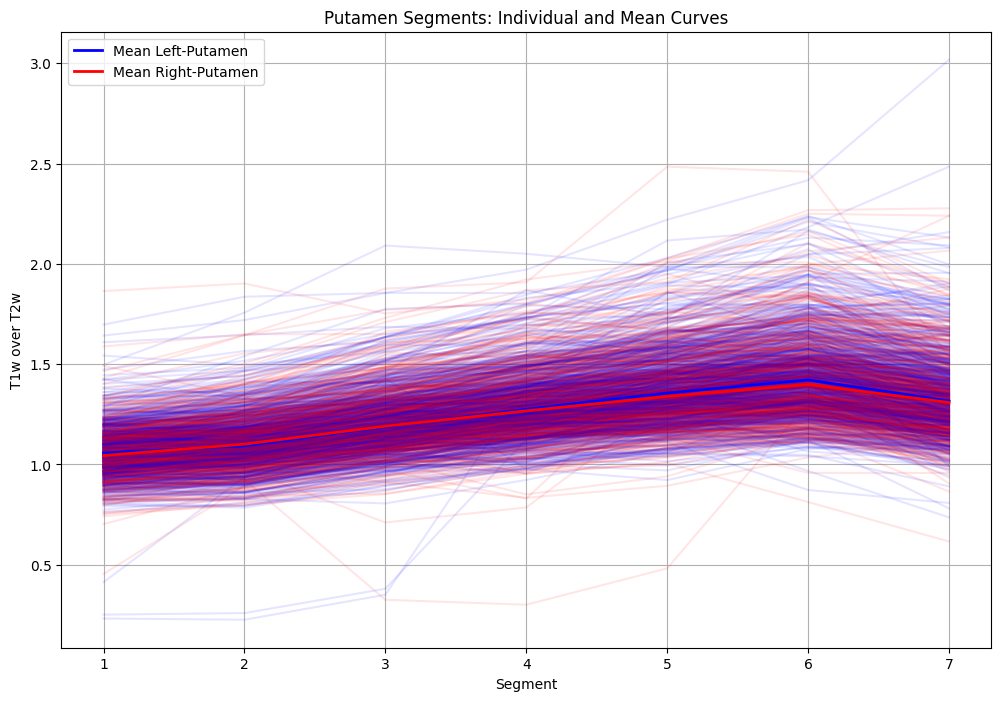

In [293]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Tracer les courbes transparentes pour chaque sujet
for subject in df_filtered.index:
    ax.plot(range(1, len(left_columns) + 1), df_filtered.loc[subject, left_columns], color='blue', alpha=0.1)
    ax.plot(range(1, len(right_columns) + 1), df_filtered.loc[subject, right_columns], color='red', alpha=0.1)

# Tracer les moyennes en bleu et rouge foncé
ax.plot(range(1, len(left_columns) + 1), df_filtered[left_columns].median(), color='blue', label='Mean Left-Putamen', linewidth=2)
ax.plot(range(1, len(right_columns) + 1), df_filtered[right_columns].median(), color='red', label='Mean Right-Putamen', linewidth=2)

# Ajouter les labels et la légende
ax.set_title('Putamen Segments: Individual and Mean Curves')
ax.set_xlabel('Segment')
ax.set_ylabel('T1w over T2w')
ax.set_xticks(range(1, len(left_columns) + 1))
ax.legend()
ax.grid(True)

# Définir une échelle logarithmique sur les ordonnées
#ax.set_yscale('log')

# Afficher le graphique
plt.show()

# Sauvegarder le graphique
fig.savefig("/NAS/deathrow/protocoles/predistim/screenshots/t2wLinesPlot4AllSubjs.jpg", format='jpeg')



In [294]:
mri = pl.df_mri_data_M00.copy()
mri = mri.set_index(" Code patient", drop=True)
mri.index = mri.index.astype(str).str.strip()
qc_cols = mri.filter(like='QC 3DT1', axis=1).columns.tolist()
meta_cols = [" Code patient", "Centre", "constructeur", "modèle", "antenne"]
meta_cols = [c for c in meta_cols if c in mri.columns]

In [299]:
# remapper l'index de mri en utilisant index_map
def _map_idx(i):
    key1 = "sub-" + str(i)
    key2 = key1 + "_ses-M00"
    return index_map.get(key1) or index_map.get(key2) or index_map.get(key1.replace("sub-0","sub-")) or i

new_index = [_map_idx(i) for i in mri.index.astype(str)]
# compter les non-mappés (qui restent identiques)
n_unmapped = sum(1 for old, new in zip(mri.index, new_index) if str(old) == str(new))

mri = mri.copy()
mri.index = new_index
mri.index.name = "clean_id"

print(f"Index remappé. Non-mappés : {n_unmapped} / {len(mri)}")
df_asym=df_intersection.join(mri[qc_cols + meta_cols])

#df_intersection_filtered = df_intersection[df_intersection.index.str.startswith("01-")]

# Filter out subjects with T1overT2_asymetry_seg greater than 100
# df_intersection = df_intersection[df_intersection['T1overT2_asymetry_seg'] <= 50]
# df_intersection = df_intersection[df_intersection['T1overT2_asymetry_seg'] > -50]

# Create groups based on the first two characters of the index
#df_intersection['Group'] = df_intersection.index.str.slice(0, 2)
#df_intersection_filtered = df_intersection
#df_intersection_filtered = df_intersection[~df_intersection.index.isin(df_intersection[df_intersection['Group'] == "14"].index)]
#df_intersection_filtered = df_intersection[~df_intersection.index.isin(df_intersection[df_intersection['Group'] == "06"].index)]
#df_intersection_filtered = df_intersection_filtered[~df_intersection_filtered.index.isin(df_intersection_filtered[df_intersection_filtered['Group'] == "07"].index)]

# Filter out rows where motor_symptom_asymetry is greater than 1 or less than -1
#df_intersection = df_intersection[(df_intersection['motor_symptom_asymetry'] <= 1) & (df_intersection['motor_symptom_asymetry'] >= -1)]


#df_asym = df_asym[~df_asym.index.isin(df_asym[df_asym['modèle'] == "Skyra"].index)]
#df_asym = df_asym[df_asym.index.isin(df_asym[df_asym['constructeur'] == "Philips"].index)]
#df_asym = df_asym[df_asym.index.isin(df_asym[df_asym['constructeur'] == "Siemens"].index)]
#df_asym = df_asym[~df_asym.index.isin(df_asym[df_asym['constructeur'] == "Siemens"].index)]

# Create an interactive scatter plot with Plotly
fig = px.scatter(
    df_asym,
    y='motor_symptom_asymetry',
    x='T1overT2_asymetry_seg',
    color='constructeur',  # Use 'Group' column to assign colors
    hover_name=df_asym.index,
    labels={
        'T1overT2_asymetry_seg': 'Mean T1W/T2W ratio asymmetry over segments 5 to 7',
        'motor_symptom_asymetry': 'Motor Symptom Asymmetry (Right Minus Left)'
    },
    title="Interactive Scatter Plot of Radiological Asymmetry vs Motor Symptom Asymmetry"
)

#Ajouter les axes x=0 et y=0 en gris pointillé
fig.add_shape(
    type="line",
    x0=df_asym['T1overT2_asymetry_seg'].min(),
    x1=df_asym['T1overT2_asymetry_seg'].max(),
    y0=0, y1=0,
    line=dict(color="gray", dash="dot")
)

fig.add_shape(
    type="line",
    x0=0, x1=0,
    y0=df_asym['motor_symptom_asymetry'].min(),
    y1=df_asym['motor_symptom_asymetry'].max(),
    line=dict(color="gray", dash="dot")
)

# Calculer la droite de régression
X = df_asym['T1overT2_asymetry_seg']
y = df_asym['motor_symptom_asymetry']
X = sm.add_constant(X)  # Ajouter une constante pour le modèle
model = sm.OLS(y, X).fit()
df_asym['regression_line'] = model.predict(X)

# Ajouter la droite de régression au graphique
fig.add_trace(
    px.line(
        df_asym,
        x='T1overT2_asymetry_seg',
        y='regression_line'
    ).data[0]
)
# Calculer le R² et la p-value
r_squared = model.rsquared
p_value = model.pvalues.iloc[1]

# Afficher les résultats
print(f"R²: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")

fig.write_image("/NAS/deathrow/protocoles/predistim/screenshots/scatter_T1woverT2w_N4norm_asymmetry_vs_motor_symptom_asymmetry_AllPatients.jpg", format='jpeg')

fig.show()

Index remappé. Non-mappés : 791 / 791
R²: 0.0128
P-value: 5.4633e-03


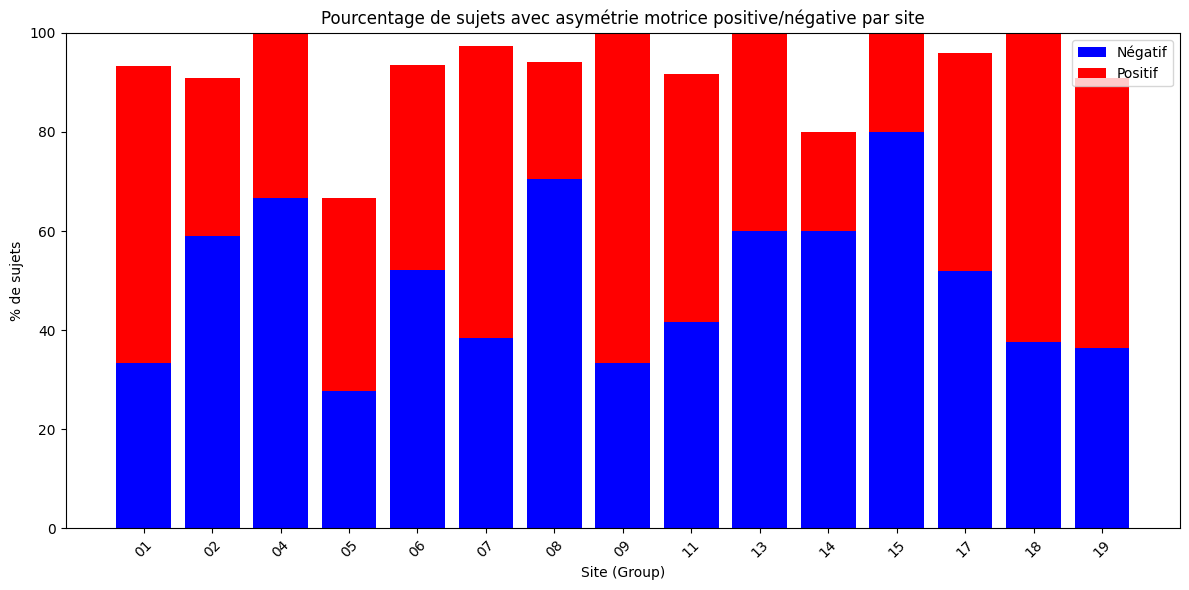

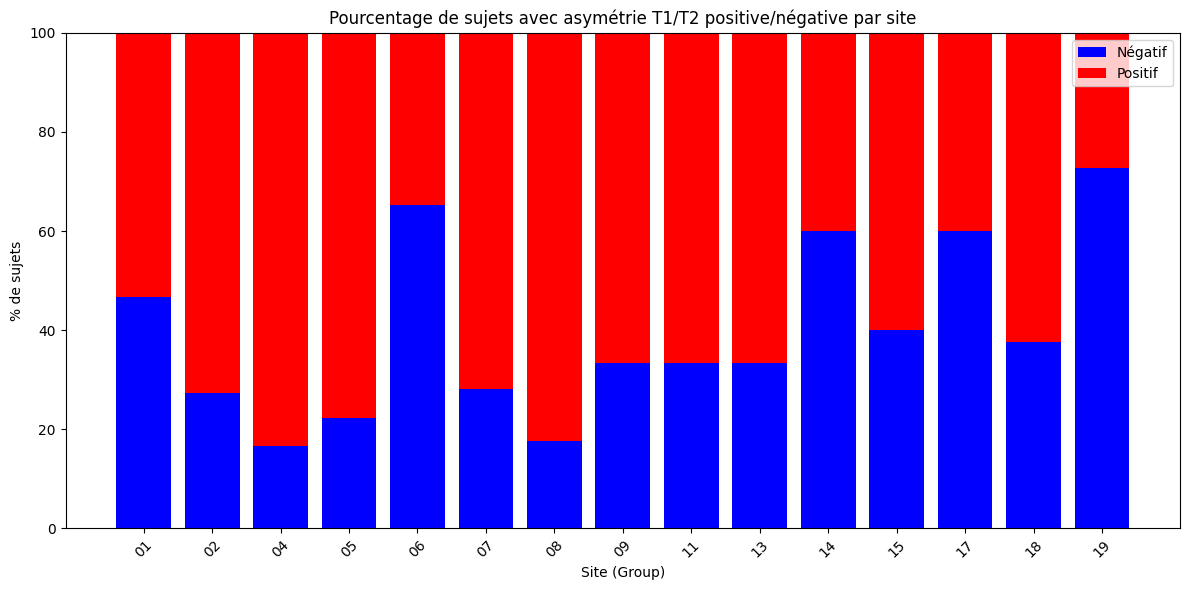

In [173]:
# Calculer le pourcentage de valeurs positives et négatives par site (Group)
summary = df_intersection.groupby('Group').apply(
    lambda g: pd.Series({
        'motor_symptom_asym_pos_%': (g['motor_symptom_asymetry'] > 0).mean() * 100,
        'motor_symptom_asym_neg_%': (g['motor_symptom_asymetry'] < 0).mean() * 100,
        'T1overT2_asym_pos_%': (g['T1overT2_asymetry_seg'] > 0).mean() * 100,
        'T1overT2_asym_neg_%': (g['T1overT2_asymetry_seg'] < 0).mean() * 100,
        'n_subjects': len(g)
    })
)

import matplotlib.pyplot as plt

# Préparer les données pour le graphique
pos = summary['motor_symptom_asym_pos_%']
neg = summary['motor_symptom_asym_neg_%']
groups = summary.index
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les barres négatives (bleu) et positives (rouge) empilées
ax.bar(groups, neg, color='blue', label='Négatif')
ax.bar(groups, pos, bottom=neg, color='red', label='Positif')

ax.set_ylabel('% de sujets')
ax.set_xlabel('Site (Group)')
ax.set_title('Pourcentage de sujets avec asymétrie motrice positive/négative par site')
ax.set_ylim(0, 100)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()

# Préparer les données pour le graphique
pos = summary['T1overT2_asym_pos_%']
neg = summary['T1overT2_asym_neg_%']
groups = summary.index
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les barres négatives (bleu) et positives (rouge) empilées
ax.bar(groups, neg, color='blue', label='Négatif')
ax.bar(groups, pos, bottom=neg, color='red', label='Positif')

ax.set_ylabel('% de sujets')
ax.set_xlabel('Site (Group)')
ax.set_title('Pourcentage de sujets avec asymétrie T1/T2 positive/négative par site')
ax.set_ylim(0, 100)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()

Traitement du patient : sub-01031FB_ses-M00
freeview -layout 1 -viewport axial /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01031FB_ses-M00/t1overt2_norm_PSR.nii.gz:grayscale=0,10 /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01031FB_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-01031FB_ses-M00/mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii:colormap=lut:opacity=0.5 /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-01031FB_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-01031FB_ses-M00/mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii:colormap=lut:opacity=0.5;


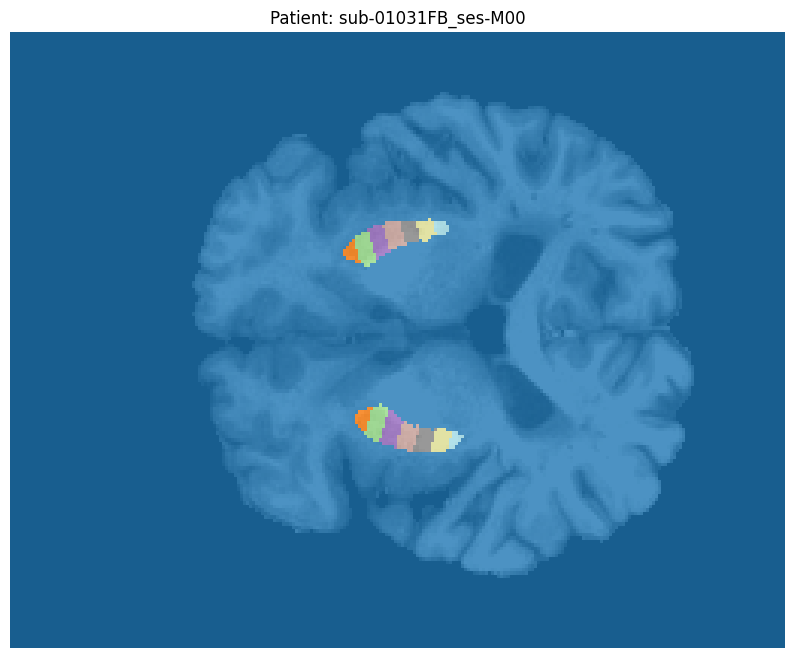

[1.0128770451182905, 1.0364847333884677, 1.2177925331357085, 1.310805204120117, 1.392588354828881, 1.4497837302209706, 1.3387932541824523, 0.9030384545279021, 0.9441467740451315, 1.1271619027515627, 1.189528120574595, 1.2945383011785327, 1.3358267441608802, 1.2428639459290676]


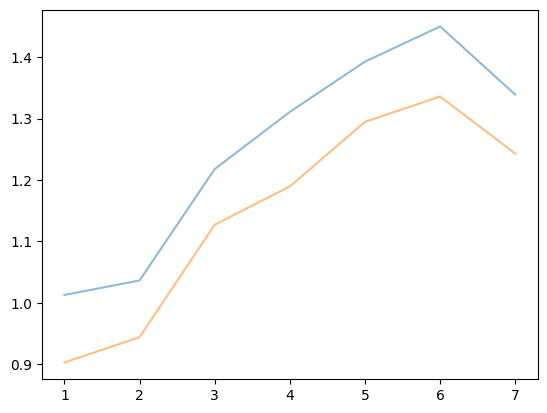

In [174]:
base_dir = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2"

for patient_dir in glob.glob(os.path.join(base_dir, "sub-01031*_ses-M00")):
    patient_id = os.path.basename(patient_dir)
    print(f"Traitement du patient : {patient_id}")

    # Chemins des fichiers pour le patient actuel
    t1overt2_file = os.path.join(patient_dir, "t1overt2_norm_PSR.nii.gz")
    
    #left_seg_file = os.path.join(patient_dir, "mrGrad", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii")
    left_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii")
    right_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii")

    print(f"freeview -layout 1 -viewport axial {t1overt2_file}:grayscale=0,10 {right_seg_file}:colormap=lut:opacity=0.5 {left_seg_file}:colormap=lut:opacity=0.5;")
    
    # Extract the patient ID and format it to match df_cleaned.index
    patient_id = os.path.basename(patient_dir)
    subject = patient_id.replace("sub-", "").replace("_ses-M00", "")
    subject = subject[:2] + "-" + subject[2:-2]
    if subject in df_cleaned.index:
        # Lire les images NIfTI
        t1overt2_img = nib.load(t1overt2_file)
        t1overt2_data = t1overt2_img.get_fdata()

        left_seg_img = nib.load(left_seg_file)
        left_seg_data = left_seg_img.get_fdata()

        right_seg_img = nib.load(right_seg_file)
        right_seg_data = right_seg_img.get_fdata()

        # Créer une figure pour le patient actuel
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Créer une table de couleurs pour les segmentations
        colors = cm.tab20(np.linspace(0, 1, 20))
        cmap = ListedColormap(colors)

        # Afficher l'image T1/T2 en niveaux de gris
        slice_idx = np.argmax(np.sum(left_seg_data, axis=(0, 2)))  # Trouver la slice avec la plus grande intégrale

        # Afficher les segmentations avec la table de couleurs et une transparence
        left_seg_slice = left_seg_data[:, slice_idx,:].T
        right_seg_slice = right_seg_data[:, slice_idx,:].T

        # Combiner les segmentations gauche et droite
        combined_seg_slice = left_seg_slice + right_seg_slice
        combined_seg_slice = np.where(combined_seg_slice > 0, combined_seg_slice, 0)

        min_val = np.percentile(t1overt2_data[:, slice_idx, :], 5)
        max_val = np.percentile(t1overt2_data[:, slice_idx, :], 95)
        ax.imshow(t1overt2_data[:, slice_idx, :].T, cmap='gray', origin='lower', aspect='auto', vmin=min_val, vmax=max_val)
        ax.imshow(combined_seg_slice, cmap=cmap, origin='lower', alpha=0.8, aspect='auto')

        # Ajouter un titre avec l'ID du patient
        ax.set_title(f"Patient: {patient_id}")
        ax.axis('off')
        
        plt.show()

        # Calculate the mean of t1overt2_data for each ROI in left_seg_data
        rois_values = []
        for roi in range(1,8):
            roi_mask = left_seg_data == roi
            roi_mean = t1overt2_data[roi_mask].mean()
            rois_values.append(roi_mean)

        for roi in range(1,8):
            roi_mask = right_seg_data == roi
            roi_mean = t1overt2_data[roi_mask].mean()
            rois_values.append(roi_mean)

        print(rois_values)
        plt.plot(range(1, 8), rois_values[:7], alpha=0.5, label=f"{subject} (Left)")
        plt.plot(range(1, 8), rois_values[7:], alpha=0.5, label=f"{subject} (Right)")
        plt.show()

In [175]:
# Chemin vers le répertoire contenant les données des patients
base_dir = "/NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2"

# Créer un fichier PDF pour sauvegarder les figures
# pdf_filename = os.path.join(base_dir, "negatoscope_figures_t1overt2_new.pdf")
pdf_filename = os.path.join(base_dir, "negatoscope_figures_T1overT2_N4_Allsites.pdf")

sorted_patient_dirs = sorted(glob.glob(os.path.join(base_dir, "sub-06*00")))

with PdfPages(pdf_filename) as pdf:
    # Parcourir les répertoires des patients
    # for patient in df_intersection.index:
    for dir_subj in sorted_patient_dirs :

        patient_id=dir_subj.split("/")[-1]
        #patient=index_map.get(sorted_patient_dirs[0].split("/")[-1][4:11])

        # Extraire l'ID du patient à partir du nom du répertoire
        #patient_id = inverse_index_map.get(patient) + "_ses-M00"
        patient_dir = os.path.join(base_dir, f"{patient_id}")
        
        # print(f"Traitement du patient : {patient_id}")

        # Chemins des fichiers pour le patient actuel
        # t1overt2_file = os.path.join(
        # , "t1overt2_norm_PSR.nii.gz")
#        t1overt2_file = os.path.join("/NAS/deathrow/protocoles/predistim/R2",patient_id[4:11] ,"R2_lin_3DT1.nii.gz")
        #t1overt2_file = os.path.join(patient_dir, "t2_LAS_rlon3DT1.nii.gz")
        t1overt2_file = os.path.join(patient_dir, "T1overT2_N4_medianNorm.nii.gz")
        #t1overt2_file = os.path.join(patient_dir, "QSMover_PSR.nii.gz")
        #t1overt2_file = os.path.join(patient_dir, "r2_norm_PSR.nii.gz")
        #t1overt2_file = os.path.join(patient_dir, "t1_PSR.nii.gz")
        left_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii")
        right_seg_file = os.path.join(patient_dir, "N4normalised", "mrGradSeg", "subjectgroup_1", patient_id, "mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii")

        print(patient_id, t1overt2_file, left_seg_file, right_seg_file)
        # Vérifier si les fichiers existent
        if not all(os.path.exists(f) for f in [t1overt2_file, left_seg_file, right_seg_file]):
             print(f"Fichiers manquants pour le patient {patient_id}, passage au suivant.")
             continue

        print(f"freeview -layout 1 -viewport axial {t1overt2_file} {right_seg_file}:colormap=lut:opacity=0.5 {left_seg_file}:colormap=lut:opacity=0.5;")
        print(f"rm {patient_dir}_patient_id_*-putamen_axis1_7segments_t2w_values.txt")

        # Lire les images NIfTI
        t1overt2_img = nib.load(t1overt2_file)
        t1overt2_data = t1overt2_img.get_fdata()

        left_seg_img = nib.load(left_seg_file)
        left_seg_data = left_seg_img.get_fdata()

        right_seg_img = nib.load(right_seg_file)
        right_seg_data = right_seg_img.get_fdata()

        # Créer une figure pour le patient actuel
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Créer une table de couleurs pour les segmentations
        colors = cm.tab20(np.linspace(0, 1, 20))
        cmap = ListedColormap(colors)

        # Afficher l'image T1/T2 en niveaux de gris
        slice_idx = np.argmax(np.sum(left_seg_data, axis=(0, 2)))  # Trouver la slice avec la plus grande intégrale

        # Afficher les segmentations avec la table de couleurs et une transparence
        left_seg_slice = left_seg_data[:, slice_idx,:].T
        right_seg_slice = right_seg_data[:, slice_idx,:].T

        # Combiner les segmentations gauche et droite
        combined_seg_slice = left_seg_slice + right_seg_slice
        combined_seg_slice = np.where(combined_seg_slice > 0, combined_seg_slice, 0)

        ################################BARYCENTER to flip segments 1 and 7 if needed##########################
        # Calculer les coordonnées du barycentre pour les ROIs 1 et 7 pour left et right
        # Barycentre pour le ROI dans la segmentation gauche
        
        # left_coords_1 = np.argwhere(left_seg_data == 1)
        # left_barycenter_1 = np.mean(left_coords_1, axis=0) if left_coords_1.size > 0 else None

        # left_coords_7 = np.argwhere(left_seg_data == 7)
        # left_barycenter_7 = np.mean(left_coords_7, axis=0) if left_coords_7.size > 0 else None

        # if left_barycenter_1[0] > left_barycenter_7[0]:
        #     print(f"python inverseROInumber.py {left_seg_file}")

        # # Barycentre pour le ROI dans la segmentation droite
        # right_coords_1 = np.argwhere(right_seg_data == 1)
        # right_barycenter_1 = np.mean(right_coords_1, axis=0) if right_coords_1.size > 0 else None

        # right_coords_7 = np.argwhere(right_seg_data == 7)
        # right_barycenter_7 = np.mean(right_coords_7, axis=0) if right_coords_7.size > 0 else None

        # if right_barycenter_1[0] > right_barycenter_7[0]:
        #     print(f"python inverseROInumber.py {right_seg_file}")

        min_val = np.percentile(t1overt2_data[:, slice_idx, :], 5)
        max_val = np.percentile(t1overt2_data[:, slice_idx, :], 95)
        ax.imshow(t1overt2_data[:, slice_idx, :].T, cmap='gray', origin='lower', aspect='auto', vmin=min_val, vmax=max_val)
        ax.imshow(combined_seg_slice, cmap=cmap, origin='lower', alpha=0.8, aspect='auto')

        # Ajouter un titre avec l'ID du patient
        ax.set_title(f"Patient: {patient_id}")
        ax.axis('off')
        
        #plt.show()
        # Ajouter la figure au PDF
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"PDF sauvegardé sous le nom : {pdf_filename}")


sub-06001NJ_ses-M00 /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-06001NJ_ses-M00/T1overT2_N4_medianNorm.nii.gz /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-06001NJ_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-06001NJ_ses-M00/mrGradSeg_t1overt2_left-putamen_axis1_7segments.nii /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-06001NJ_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-06001NJ_ses-M00/mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii
freeview -layout 1 -viewport axial /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-06001NJ_ses-M00/T1overT2_N4_medianNorm.nii.gz /NAS/deathrow/protocoles/predistim/20250707-120649_MAD_pdt2se/derivatives/mrGRAD_T1overT2/sub-06001NJ_ses-M00/N4normalised/mrGradSeg/subjectgroup_1/sub-06001NJ_ses-M00/mrGradSeg_t1overt2_right-putamen_axis1_7segments.nii:col